# How do Director's Impact Public Opinion? 

#### Import libraries and necessary DataFrames to get us started

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
imdb_df4 = pd.read_csv('Data/imdb.title.crew.csv') #movie id | directors id | ...
imdb_df6 = pd.read_csv('Data/imdb.title.ratings.csv') #movie id | Average rating | number of votes
name_df = pd.read_csv('Data/imdb.name.basics.csv') #director id | Name | ...

Merge DataFrame imdb_df4  With DataFrame imdb_df6

Movie ID | Directors ID --onto-- Movie ID | Average Rating | Number of Votes

The cell below completes a right-merge of imdb_df4 onto imdb_df6 across the shared index 'tconst'. This maintains the director's index and removes the extraneous values from imdb_df6 that don't match up with the director index.

In [3]:
imdb_df10 = imdb_df6.merge(imdb_df4, left_on='tconst', right_on = 'tconst', how = 'right')
print('This is imdb_df10 info:')
imdb_df10.info()
print('This is imdb_df4 info:')
imdb_df4.info()
print('This is imdb_df6 info:')
imdb_df6.info()

This is imdb_df10 info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 146144 entries, 0 to 146143
Data columns (total 5 columns):
tconst           146144 non-null object
averagerating    73856 non-null float64
numvotes         73856 non-null float64
directors        140417 non-null object
writers          110261 non-null object
dtypes: float64(2), object(3)
memory usage: 6.7+ MB
This is imdb_df4 info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146144 entries, 0 to 146143
Data columns (total 3 columns):
tconst       146144 non-null object
directors    140417 non-null object
writers      110261 non-null object
dtypes: object(3)
memory usage: 3.3+ MB
This is imdb_df6 info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73856 entries, 0 to 73855
Data columns (total 3 columns):
tconst           73856 non-null object
averagerating    73856 non-null float64
numvotes         73856 non-null int64
dtypes: float64(1), int64(1), object(1)
memory usage: 1.7+ MB


In this cell I am removing the NaN values that would otherwise disrupt the analysis. We also see from above, that the dataframes are not the same size. This will result in a significant number of NaNs. While I have 140,000+ directors in imdb_df4, I only have 73,856 reviews/rankings. Fabricating values to fill the NaN's is a possibility. However, fabricating a summary statistic to represent the missing director's reviews and votes would be inappropriate. This is attributed to the small sample size of each director. Summary statistics would be highly volatile, and would cause more harm than good.

In [4]:
imdb_df10.dropna(subset = ['averagerating'], inplace=True)
imdb_df10.dropna(subset = ['numvotes'], inplace = True)  
imdb_df10.dropna(subset = ['directors'], inplace = True)
imdb_df10.drop(['writers'],inplace = True, axis = 1)

The input below creates a new column called 'pos_reaction'. This is done to better analyse the impact of the number of votes and the review rating. 

In [5]:
imdb_df10['pos_reaction'] = imdb_df10['averagerating'] * imdb_df10['numvotes']

Below, we are grouping by the director, and summing to convert the dataframe groupby type to a dataframe type. The unique directors are also formated as an index to be referred to later. 

In [42]:
pos_reaction = pd.DataFrame(imdb_df10.groupby('directors').sum())['pos_reaction']
pos_reaction.index;

Here the code is counting the unique itterations of the directors, as well as the number of counts that it shows up.
We initialize an empty dictionary, to place key, value pairs of the director index and the average positive reaction that gets synthisized in the for loop.

In [43]:
directors, counts = np.unique(imdb_df10['directors'], return_counts=True)

dir_pos = {}
for director, count in zip(directors, counts):
    dir_pos[director] = ((pos_reaction.loc[director])/count) #gets the total pos_reaction / count of films made 

Below, is the result of the dictionary, now converted over to a dataframe type object, titled: top_10_directors

In [44]:
top_10_directors = pd.DataFrame(list(dir_pos.items()), columns=['directors', 'avg_positive_reaction'])
top_10_directors.head()

,directors,avg_positive_reaction
0,nm0000080,31167.300
1,nm0000095,759245.975
2,nm0000108,726711.650
3,nm0000110,1529239.040
4,nm0000118,214407.200


Since we're only concerned about the top 10 directors, we sort the table based on the average positive reaction. Then reassigning the working data frame as the first 10 values. In anticipation of our next process, we reset the index so we may access it more easily in the following steps.

In [26]:
top_10_directors = top_10_directors.sort_values('avg_positive_reaction', ascending = False).head(10).reset_index()

#### The purpose of the next few lines is to seperate the directors column into 2 columns, to account for multiple directors
##### The reason being, when multiple directors contribute to the film, the database simply adds the additional director into the column. By spliting the column at a ',' we are able to refrence each director's specific ID to investigate the person's name, and any additional information we might need.

Below, we define a function that trys to split the column at a ',' but if it throws an error, it will return an empty string to the new column, instead of crashing the translation.

In [27]:
def split_column(director_str):
    mk_split = director_str.split(',')
    try:
        return mk_split[1]
    except:
        return ''

Here we approach splitting the column in 2 different manners:

The first line will split the first director off at the commam, and insert it into a new column labeled 'director1'

The second line applies the function and will circumvent any error that might be triggered by indexes not matching.

In [28]:
top_10_directors['director1'] = top_10_directors['directors'].apply(lambda x: x.split(',')[0])
top_10_directors['director2'] = top_10_directors['directors'].apply(split_column)
top_10_directors

,index,directors,avg_positive_reaction,director1,director2
0,7622,nm0634240,1.067972e+07,nm0634240,
1,18805,nm1783265,6.566776e+06,nm1783265,
2,438,nm0004306,6.325371e+06,nm0004306,
3,10404,nm0881279,5.662409e+06,nm0881279,
4,8989,"nm0761498,nm0213450",4.951522e+06,nm0761498,nm0213450
5,10853,nm0923736,4.852477e+06,nm0923736,
6,8862,"nm0751577,nm0751648",4.833245e+06,nm0751577,nm0751648
7,62,nm0000399,4.523357e+06,nm0000399,
8,3075,"nm0230032,nm0215455",4.396684e+06,nm0230032,nm0215455
9,608,nm0009190,3.984295e+06,nm0009190,


#### The objective of this next section is to merge name_df onto top_10_directors. 
##### This will require 2 merges due to the fact that we are finding the corresponding director for 2 columns.

Here we are opening a new csv file that combines the director refrence number and the paired name

In [29]:
name_df = pd.read_csv('Data/imdb.name.basics.csv')
name_df['name_directors'] = name_df['primary_name']

In [30]:
name_df.head(1)

,nconst,primary_name,birth_year,death_year,primary_profession,known_for_titles,name_directors
0,nm0061671,Mary Ellen Bauder,NaN,NaN,"miscellaneous,production_manager,producer","tt0837562,tt2398241,tt0844471,tt0118553",Mary Ellen Bauder


In [31]:
top_10_directors.head(1)

,index,directors,avg_positive_reaction,director1,director2
0,7622,nm0634240,10679723.7,nm0634240,


This merge is being excecuted on top_10_directors, maintaining the index on the left-hand of the function.
The shared column thats being refrenced is "director1" from top_10_directors and "nconst" from name_df.

In [32]:
top_10_directors_names = top_10_directors.merge(name_df, left_on = 'director1', right_on = 'nconst', how = 'left')
top_10_directors_names.head(1)


,index,directors,avg_positive_reaction,director1,director2,nconst,primary_name,birth_year,death_year,primary_profession,known_for_titles,name_directors
0,7622,nm0634240,10679723.7,nm0634240,,nm0634240,Christopher Nolan,1970.0,NaN,"writer,producer,director","tt0482571,tt1375666,tt5013056,tt0154506",Christopher Nolan


A similar process is done to link the second director to the name_df.

This time we refrence 'director2' as the left-hand pair to be linked with 'nconst' from the name_df.

In [33]:
top_10_directors_names2 = top_10_directors_names.merge(name_df, left_on = 'director2', right_on = 'nconst', how = 'left')
top_10_directors_names2.head(1)

,index,directors,avg_positive_reaction,director1,director2,nconst_x,primary_name_x,birth_year_x,death_year_x,primary_profession_x,known_for_titles_x,name_directors_x,nconst_y,primary_name_y,birth_year_y,death_year_y,primary_profession_y,known_for_titles_y,name_directors_y
0,7622,nm0634240,10679723.7,nm0634240,,nm0634240,Christopher Nolan,1970.0,NaN,"writer,producer,director","tt0482571,tt1375666,tt5013056,tt0154506",Christopher Nolan,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The above dataframe is very messy as a result of the merge. 

In order to expedite the process, below, I created an empty dataframe to be populated by the data that is deemed usefull.

The final column 'Director(s)' will be refrenced in the graphing section that follows. It is simply a summation of 'Director1' and 'Director2' columns. In the event of having only one director, we replace the NaN value that is created as a result of the summation, with the value from 'Director1'.

In [34]:
final_df = pd.DataFrame()
final_df['Director_ID'] = top_10_directors_names2['directors']
final_df['Avg_Positive_Reaction'] = top_10_directors_names2['avg_positive_reaction']
final_df['Director_1'] = top_10_directors_names2['primary_name_x']
final_df['Director_2'] = top_10_directors_names2['primary_name_y']
#final_df['Director(s)'] = pd.Series()
final_df['Director(s)'] = final_df['Director_1'] + ', ' + final_df['Director_2']
final_df['Director(s)'].fillna(final_df['Director_1'], inplace = True)

In [35]:
final_df 

,Director_ID,Avg_Positive_Reaction,Director_1,Director_2,Director(s)
0,nm0634240,1.067972e+07,Christopher Nolan,NaN,Christopher Nolan
1,nm1783265,6.566776e+06,Tim Miller,NaN,Tim Miller
2,nm0004306,6.325371e+06,George Miller,NaN,George Miller
3,nm0881279,5.662409e+06,Lee Unkrich,NaN,Lee Unkrich
4,"nm0761498,nm0213450",4.951522e+06,Chris Sanders,Dean DeBlois,"Chris Sanders, Dean DeBlois"
5,nm0923736,4.852477e+06,Joss Whedon,NaN,Joss Whedon
6,"nm0751577,nm0751648",4.833245e+06,Anthony Russo,Joe Russo,"Anthony Russo, Joe Russo"
7,nm0000399,4.523357e+06,David Fincher,NaN,David Fincher
8,"nm0230032,nm0215455",4.396684e+06,Pete Docter,Ronnie Del Carmen,"Pete Docter, Ronnie Del Carmen"
9,nm0009190,3.984295e+06,J.J. Abrams,NaN,J.J. Abrams


In [36]:
imdb_df10.loc[imdb_df10['directors'] == 'nm0634240']

,tconst,averagerating,numvotes,directors,pos_reaction
8738,tt1345836,8.4,1387769.0,nm0634240,11657259.6
24920,tt0816692,8.6,1299334.0,nm0634240,11174272.4
49039,tt5013056,7.9,466580.0,nm0634240,3685982.0
63498,tt1375666,8.8,1841066.0,nm0634240,16201380.8


#### This bar plot illustrates that when compared to his peers in the group Christorpher Nolan has a significantly higher positive reaction on those viewing his films.

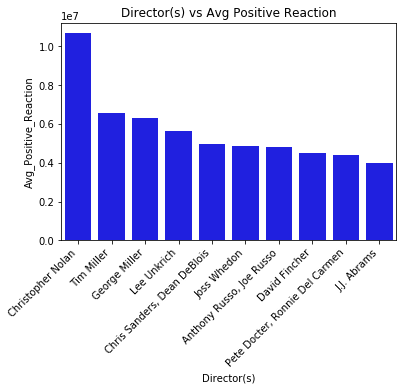

In [55]:
directors = sns.barplot(x= final_df['Director(s)'], y= final_df['Avg_Positive_Reaction'], color= 'blue')
directors.set_xticklabels(directors.get_xticklabels(), rotation=45, ha='right');
plt.title('Director(s) vs Avg Positive Reaction');

# How do Sequels Affect Cashflow?


#### Import the necesarry libraries 

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#### Import dataframe

In [57]:
tn_df10 = pd.read_csv('Data/tn.movie_budgets.csv')

Below, we are modifying the columns in tn_df10 to drop the non-numerical values that show up, ',' and '$' and convert it to an integer.

This will allow us to further manipulate the dataframe to answer our question.

In [59]:
tn_df10['production_budget'] = tn_df10['production_budget'].astype(str)
tn_df10['production_budget'] = tn_df10['production_budget'].str.replace(",", "", regex = True)
tn_df10['production_budget'] = tn_df10['production_budget'].str.replace("$", "", regex = True)
tn_df10['production_budget'] = tn_df10['production_budget'].astype(int)

tn_df10['domestic_gross'] = tn_df10['domestic_gross'].astype(str)
tn_df10['domestic_gross'] = tn_df10['domestic_gross'].str.replace(",", "", regex = True)
tn_df10['domestic_gross'] = tn_df10['domestic_gross'].str.replace("$", "", regex = True)
tn_df10['domestic_gross'] = tn_df10['domestic_gross'].astype(int)

tn_df10['worldwide_gross'] = tn_df10['worldwide_gross'].astype(str)
tn_df10['worldwide_gross'] = tn_df10['worldwide_gross'].str.replace(",", "", regex = True)
tn_df10['worldwide_gross'] = tn_df10['worldwide_gross'].str.replace("$", "", regex = True)
tn_df10['worldwide_gross'] = tn_df10['worldwide_gross'].astype(int)

In the cell below, we are creating a new column that subtracts the production budget column from the worldwide_gross column.

This column with give us the profit of the film, which is a good indication of how the film performed vs its peers.

In [72]:
tn_df10['profit'] = tn_df10['worldwide_gross'] - tn_df10['production_budget']

Below is shoing the resulting table with the new column profit added at the end.

In [73]:
tn_df10.head(50)

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,profit
0,1,"Dec 18, 2009",Avatar,425000000,760507625,2776345279,2351345279
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,635063875
2,3,"Jun 7, 2019",Dark Phoenix,350000000,42762350,149762350,-200237650
3,4,"May 1, 2015",Avengers: Age of Ultron,330600000,459005868,1403013963,1072413963
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747,999721747
5,6,"Dec 18, 2015",Star Wars Ep. VII: The Force Awakens,306000000,936662225,2053311220,1747311220
6,7,"Apr 27, 2018",Avengers: Infinity War,300000000,678815482,2048134200,1748134200
7,8,"May 24, 2007",Pirates of the Caribbean: At Worldâs End,300000000,309420425,963420425,663420425
8,9,"Nov 17, 2017",Justice League,300000000,229024295,655945209,355945209
9,10,"Nov 6, 2015",Spectre,300000000,200074175,879620923,579620923


From the table above, we are looking for similar words that would tie series together into groups Idealy there would be some sort of indetifer we could group by and automate this string search.

Below, to circumvent this gap in the data, we select a grouping of words that would be contained in sequel series, and insert them into a new dataframe that is specific to that sequel group.

From each sequel group, we take the sum to get the total profit for the sequel group.

In [74]:
pirates = tn_df10[tn_df10['movie'].str.contains('Pirates of the')]
pirates_profit = pirates['profit'].sum()

avengers = tn_df10[tn_df10['movie'].str.contains('Avengers')]
avengers_profit = avengers['profit'].sum()

star_wars = tn_df10[tn_df10['movie'].str.contains('Star Wars')]
star_wars_profit = star_wars['profit'].sum()

transformers = tn_df10[tn_df10['movie'].str.contains('Transformers')]
transformers_profit = transformers['profit'].sum()

x_men = tn_df10[tn_df10['movie'].str.contains('X-Men')]
x_men_profit = x_men['profit'].sum()

harry_potters = tn_df10[tn_df10['movie'].str.contains('Harry Potter')]
harry_potters_profit = harry_potters['profit'].sum()

fast_furious = tn_df10[tn_df10['movie'].str.contains('Furious')]
fast_furious_profit = fast_furious['profit'].sum()

jurassics = tn_df10[tn_df10['movie'].str.contains('Jurassic')]
jurassics_profit = jurassics['profit'].sum()

Here we are gouping the values from above as key-value pairs, where the key is the sequel grouping and the value is the total profit the sequel group.
This will help in converting to dataframe for further analysis.

In [75]:
profits = {'Jurassic Park': jurassics_profit, 'Fast and the Furious': fast_furious_profit, 'Harry Potter': harry_potters_profit, 'Pirates of the Carribean': pirates_profit, 'Avengers': avengers_profit, 'Starwars': star_wars_profit, 'Transformers': transformers_profit, 'X Men': x_men_profit}

Converting the dictionary into a dataframe.

In [77]:
sequel_profits = pd.DataFrame(list(profits.items()), columns=['sequel_title', 'total_profit'])

Below, we sort based on total profit.

We reset the index, for ease of refrence later.

We created a new column called "total profit billions" which is total profit devided by a billion. This will make it easier to interprete for the audience.

In [78]:
sequel_profits.sort_values('total_profit', ascending = False, inplace = True)
sequel_profits.reset_index(inplace = True)
sequel_profits['Total_profit_billions'] = (sequel_profits['total_profit'] / 1000000000)

In [79]:
sequel_profits

,index,sequel_title,total_profit,Total_profit_billions
0,5,Starwars,7789186202,7.789186
1,2,Harry Potter,6573694807,6.573695
2,0,Jurassic Park,4361979246,4.361979
3,4,Avengers,4102069476,4.102069
4,1,Fast and the Furious,3622650892,3.622651
5,6,Transformers,3392515250,3.392515
6,3,Pirates of the Carribean,3192895352,3.192895
7,7,X Men,2085643235,2.085643


Lastly, we are plotting the sequel groupings against the total profit billions.

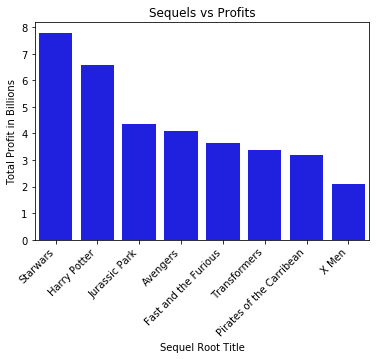

In [81]:
sequels_plt = sns.barplot(x= sequel_profits['sequel_title'], y= sequel_profits['Total_profit_billions'], color= 'blue')
sequels_plt.set_xticklabels(sequels_plt.get_xticklabels(), rotation=45, ha='right');
sequels_plt.set(xlabel = 'Sequel Root Title', ylabel = 'Total Profit in Billions')
plt.title('Sequels vs Profits');

### As a note - Each of these have significant monatary exposure outside of box office in the form of merchandise, theme parks, and spin-off movies. Upon further, crude, investigation, the profit from the entire sequel grouping is a small fraction of the profit attributed to merchandise/marketing. One hypothesis to be evaluated further is how the continuous exposure to movies in a sequel, affects the merchandise sales as compared to stand-alone movies.